# **TFG Manuel García González: Modelo DistilBERT para Text Classification**

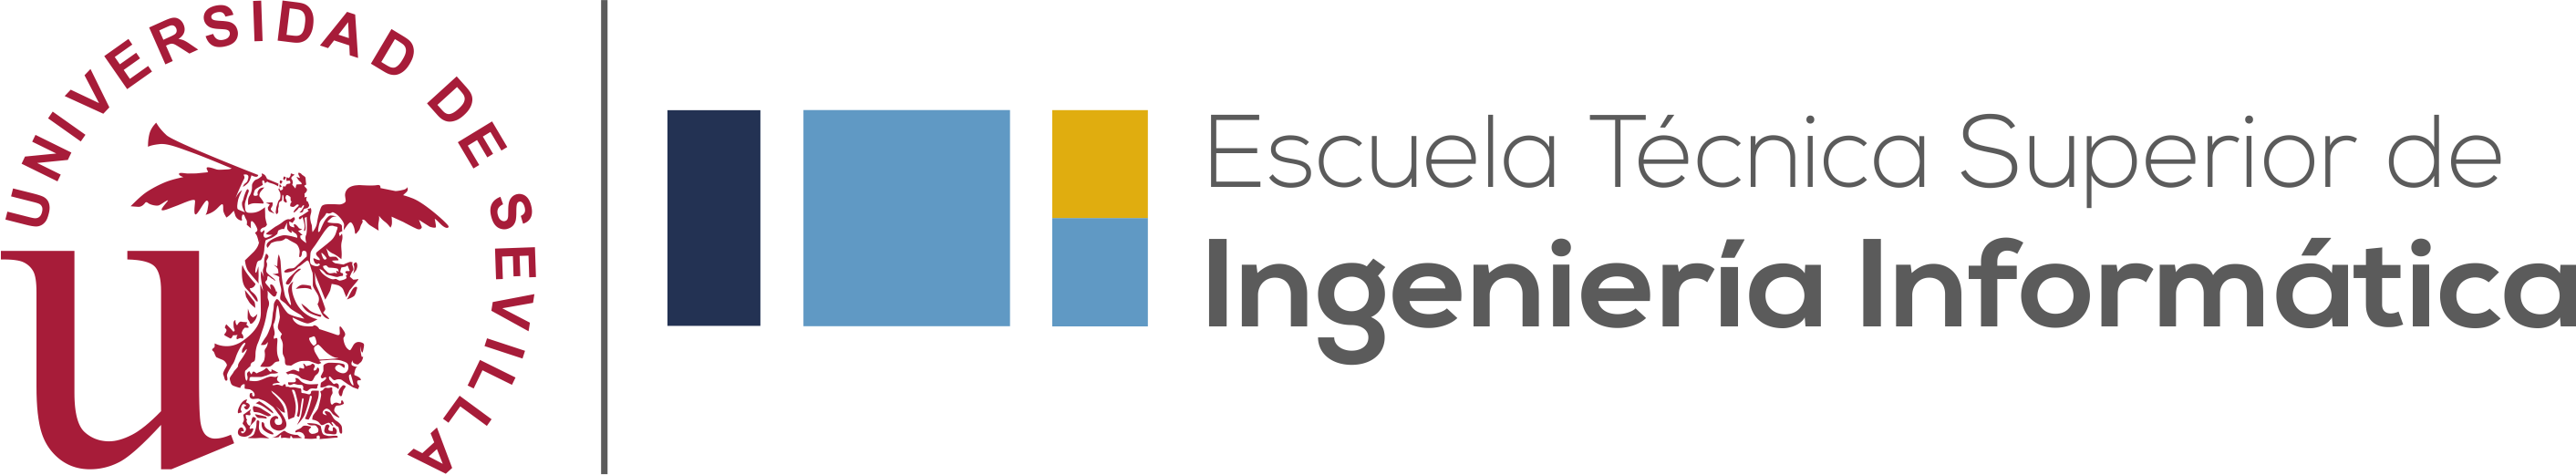

### **Importante: No ejecutar el notebook.**









La clasificación de textos es una tarea habitual del PNL, que asigna una etiqueta o clase al texto. Una de las formas más populares de clasificación de texto es el análisis de sentimiento, que asigna una etiqueta como positivo, negativo o neutro a una secuencia de texto.

Para llevar a cabo esta serie de pruebas, se implementará el modelo **distilBERT**. Este modelo, disponible dentro del portal de HugginFace, se propuso en un paper como una versión más pequeña, rápida, barata y ligera del modelo BERT (enlace del paper: https://paperswithcode.com/paper/distilbert-a-distilled-version-of-bert).

Tiene un 40% menos de parámetros que google-bert/bert-base-uncased, se ejecuta un 60% más rápido y conserva más del 95% del rendimiento de BERT según lo medido en el punto de referencia de comprensión del lenguaje GLUE.

Para cada modelo, se han de tener en cuanta las consideraciones y especificaciones de cada uno, para trabajar con el de forma óptima. En este caso, se comenta lo siguiente:

- DistilBERT no tiene token_type_ids, no es necesario indicar qué token pertenece a qué segmento. Simplemente separa sus segmentos con el token de separación tokenizer.sep_token.

- DistilBERT no tiene opciones para seleccionar las posiciones de entrada (position_idsentrada). Sin embargo, esto podría agregarse si es necesario.

- Igual que BERT pero más pequeño. Entrenado mediante destilación del modelo BERT previamente entrenado, lo que significa que ha sido entrenado para predecir las mismas probabilidades que el modelo más grande. El objetivo real es una combinación de:

    - Encontrar las mismas probabilidades que el modelo del predecesor
    
    - Predecir correctamente las fichas enmascaradas (pero sin objetivo para la siguiente oración)
    
    - Una similitud entre los estados ocultos del modelo desarrollado y el predecesor
    

También, debemos seleccionar un dataset sobre el que aplicar las tareas de text clasification. Muchos de estos están disponibles en el portal de Hugginface, y operables desde la librería Transformers.

El primer paso de todo este proceso es realizar la instalación necesaria:

In [ ]:
pip install transformers

In [ ]:
pip install torch

In [ ]:
from transformers import pipeline


In [ ]:
pip install datasets evaluate accelerate


#.

Uno de los requisitos que se han de cumplir a la hora de subir y editar modelos, es la necesidad de estar dado de alta en HugginFace, e iniciar sesión desde los propios notebooks.

Previo a esto, debemos crear el modelo vacío con el nombre deseado y generar un token del tipo "Manage" en nuestro perfil. Este token, es solicitado una vez ejecutemos el siguiente extracto de código, y al ingresarlo se activan los permisos para trabajar con los modelos creados por ese perfil.

#.

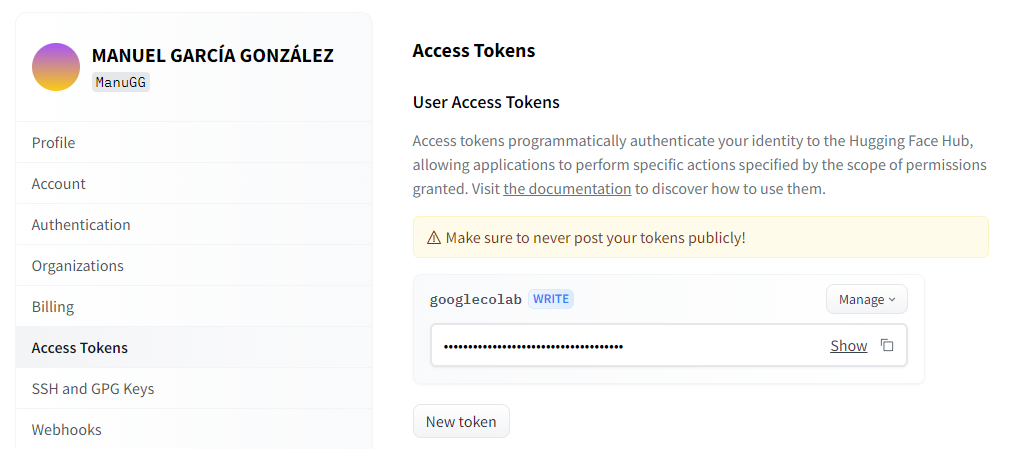

#.




#.

Una vez establecido el token de acceso, e iniciado sesión en el notebook, se ha de crear el modelo "vacío" dentro de nuestro usuario, desde la propia página de Huginface:

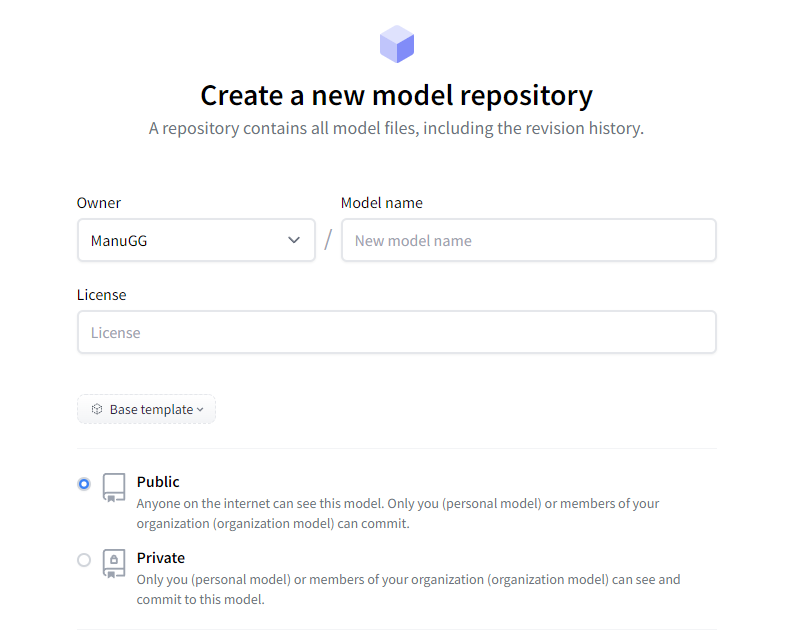

#.

Creado el modelo, este nos aparecerá reflejado la página de inicio de nuestro perfil:

#.

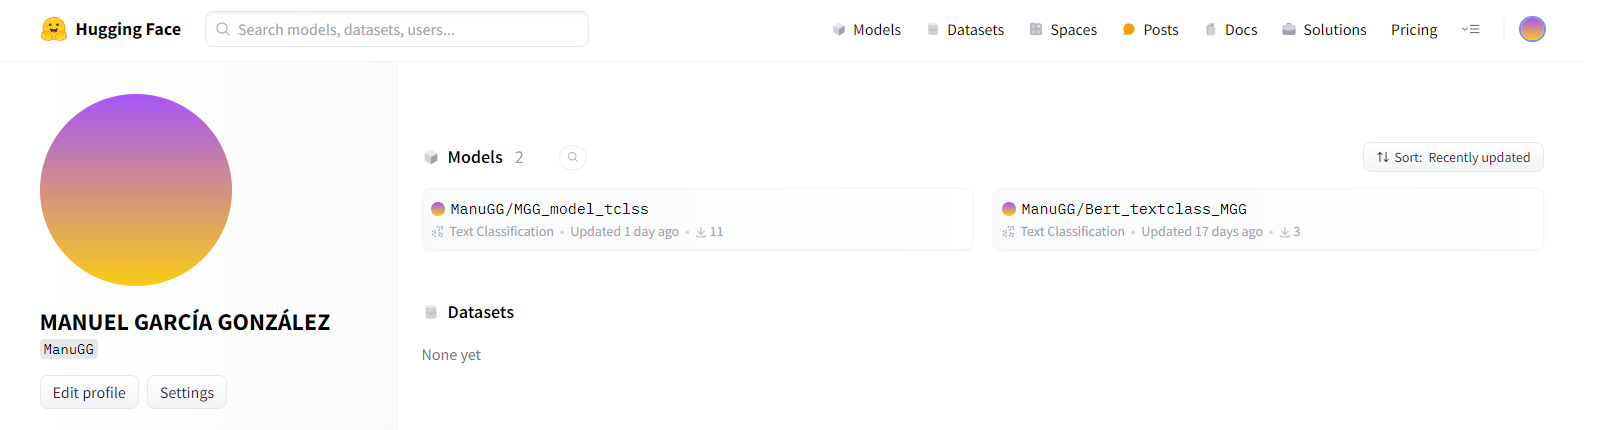

Este proceso ha resultado ser ciertamente complicado, ya que la documentación no es muy específica con los pasos a seguir previos al entrenamiento de los modelos.


#.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

#.

Tras el inicio de sesión, ya podemos comenzar con el ajuste de los modelos

Vamos a implementar un dataset llamado **"imdb"** (). Este dataset recoge un gran conjunto de datos de críticas de películas de la página IMDB. Se trata de un conjunto de datos para la clasificación binaria de opiniones que contiene muchos más datos que los anteriores conjuntos de datos de referencia. Proporcionamos un conjunto de 25.000 críticas de películas altamente polares para el entrenamiento y 25.000 para las pruebas. También hay datos adicionales sin etiquetar que ascienden hasta 50.000 entradas. En total supone un dataset de un total de 100k de entradas.

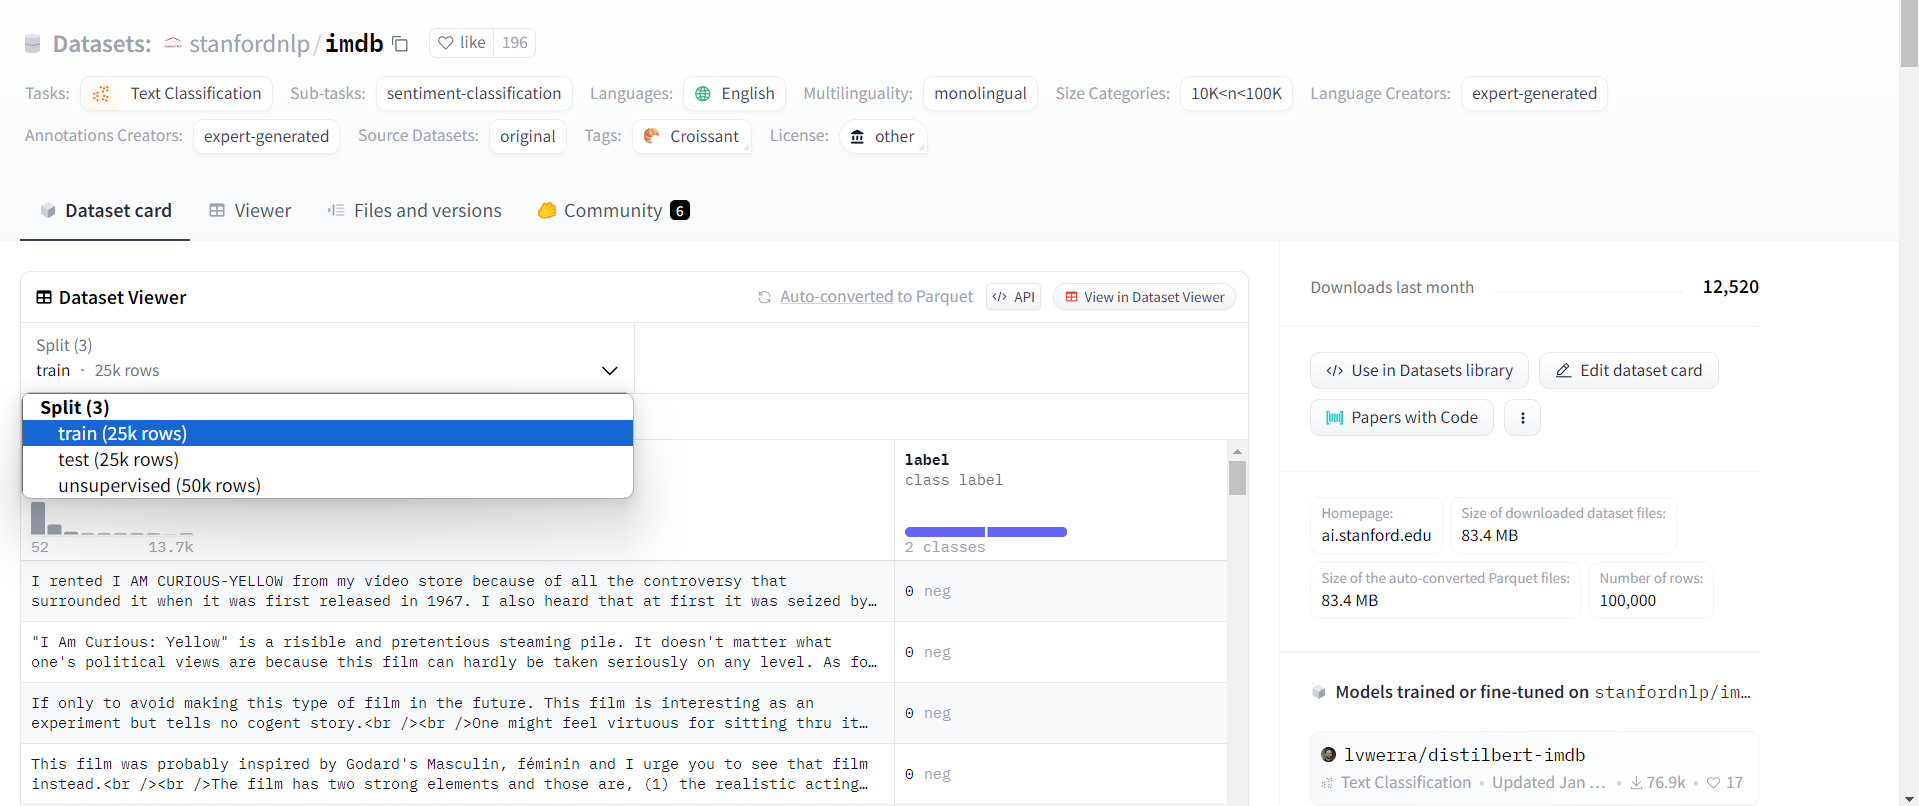

#.

Para cargar el dataset, se ha de emplear el siguiente extracto de código, utilizando la función load_dataset() de la librería datasets.

#.

In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

#.

Para comprobar que ha cargado correctamente, seleccionamos la priemra entrada del split de datos "train", a modo de ejemplo.

#.

In [ ]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

#.

Tras la comprobación, se ha continuado con el preprocesado de los datos incluidos en el dataset, comenzando con el desarrollo de un extracto de código que utilice la biblioteca Transformers de Hugging Face para cargar el tokenizador preentrenado específico asociado al DistilBERT, como se ha visto en el notebook de explicaciones.

En primer lugar, importamos la función Autotokenizar. Después, se crea una instancia donde se utiliza el método from_pretrained de AutoTokenizer para cargar el tokenizador preentrenado concreto.

Como se ha visto en la revisión de la literatura y estudio teórico, un tokenizador es una herramienta que convierte texto en una serie de tokens (palabras, subpalabras o caracteres) que el modelo de lenguaje puede entender y procesar. En el caso de los modelos de Transformers, el tokenizador también se encarga de mapear estos tokens a identificadores numéricos, añadiendo los tokens especiales necesarios (como los tokens de inicio y fin de secuencia) y realizando otras transformaciones necesarias para preparar el texto para su procesamiento por el modelo.


#.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

#.

Posteriormente se ha de idear una función para preparar los datos de entrada para el modelo de lenguaje, denominada "preprocess_function". Esta toma un conjunto de ejemplos de texto, extrae el texto relevante y lo procesa utilizando el tokenizador. El parámetro truncation=True asegura que cualquier texto que exceda la longitud máxima permitida se truncará, garantizando que los datos sean compatibles con las restricciones del modelo.

Esta función es especialmente útil cuando se trabaja con conjuntos de datos grandes y se necesita aplicar el mismo proceso de tokenización a cada entrada de texto de manera consistente y eficiente.

#.

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

#.

Una vez definido la función anterior, gracias a la función map(), se selecciona cada valor y aplica la función preprocess_function a cada ejemplo en el conjunto de datos. La función tokeniza y trunca el texto según sea necesario. El parámetro batched=True optimiza este proceso al permitir que la función se aplique a lotes de ejemplos simultáneamente. El conjunto de datos resultante, tokenized_imdb, contiene las versiones tokenizadas de las reseñas de películas, listas para ser utilizadas en modelos de procesamiento

#.

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

#.

Ahora se ha preparado un objeto DataCollatorWithPadding. Esta clase se utiliza para crear un objeto que maneja el proceso de "rellenado" (padding) de las secuencias de texto tokenizadas.

Este objeto se encarga de ajustar dinámicamente la longitud de las secuencias dentro de un lote (batch) a la longitud de la secuencia más larga presente en ese lote. En lugar de rellenar todas las secuencias del conjunto de datos a una longitud máxima fija, se hace durante la creación de cada lote. Esto es más eficiente y evita el desperdicio de espacio computacional. A este proceso se le conoce como Rellenado dinámico.

#.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#.

Con esto, los datos estarían listo para ser empleados por el modelo, pero antes de empezar a entrenar el modelo, se ha de crear un mapa de los ids esperados a sus etiquetas con id2label y label2id:



*   id2label: Este diccionario se utiliza principalmente para interpretar las salidas del modelo. Una vez que el modelo realiza una predicción, produce un identificador numérico. id2label permite traducir este identificador a una etiqueta legible como "NEGATIVE" o "POSITIVE", facilitando la comprensión de los resultados.


*   label2id: Al entrenar un modelo de clasificación, las etiquetas suelen estar en formato de texto (como "NEGATIVE" o "POSITIVE"). label2id convierte estas etiquetas de texto en identificadores numéricos que el modelo puede utilizar.



#.

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

#.

Posteriormente, es necesario incluir una métrica durante el entrenamiento, que suele ser útil para evaluar el rendimiento de tu modelo.

Para esta tarea, Se ha cargado la métrica de precisión (se verá más adelante en la evaluación de los modelos):

#.

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

#.

Tras llamar al metodo accuracy, se ha creado una función para calcular la precisión:

#.

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#.

Seguidamente, ya se puede cargar el modelo mediante **AutoModelForSequenceClassification** junto con el número de etiquetas esperadas, y los mapeos de dichas etiquetas.

#.

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#.

En este punto, sólo quedan tres pasos:


En primer lugar, definir los hiperparámetros de entrenamiento en TrainingArguments. El único parámetro necesario es output_dir, que especifica dónde guardar el modelo (en este caso concreto, se creópreviamente el modelo vacío "ManuGG/MGG_model_tclss", para almacenar aquí el modelo ajustado). Se dado la posibilidad de empujar este modelo al Hub estableciendo push_to_hub=True (es necesario estar conectado a Hugging Face para cargar su modelo como se comentaba más arriba). Al final de cada época, el Trainer evaluará la precisión y guardará el punto de control del entrenamiento.

A continuación, se desglosan cada uno de los valores definidos dentro de la clase TrainingArguments:


1.   output_dir="ManuGG/MGG_model_tclss": Este parámetro especifica el directorio donde se guardarán los resultados del entrenamiento, incluidos los puntos de control (checkpoints) del modelo y otros archivos generados durante el entrenamiento.

2. learning_rate=2e-5: Este parámetro establece la tasa de aprendizaje para el optimizador. Una tasa de aprendizaje de 2e-5 es típica para modelos de Transformers y controla la magnitud de los ajustes que se realizan a los pesos del modelo durante el entrenamiento.

3. per_device_train_batch_size=16: Define el tamaño del lote (batch size) para el entrenamiento en cada dispositivo (GPU o CPU). Un tamaño de lote de 16 significa que se procesarán 16 ejemplos de entrenamiento en paralelo en cada dispositivo.

4. per_device_eval_batch_size=16: Define el tamaño del lote para la evaluación en cada dispositivo. Esto significa que se procesarán 16 ejemplos de evaluación en paralelo en cada dispositivo.

5. num_train_epochs=2: Especifica el número de épocas para el entrenamiento. Una época implica pasar por todo el conjunto de datos de entrenamiento una vez. En este caso, el modelo se entrenará durante 2 épocas.

6. weight_decay=0.01: Este parámetro establece la tasa de decaimiento de los pesos, que es una técnica de regularización utilizada para evitar el sobreajuste al penalizar grandes pesos en el modelo.

7. evaluation_strategy="epoch": Indica que el modelo se evaluará al final de cada época. Esto ayuda a monitorizar el rendimiento del modelo a lo largo del entrenamiento y ajustar los hiperparámetros si es necesario.

8. save_strategy="epoch": Especifica que el modelo se guardará al final de cada época. Esto permite recuperar los puntos de control del modelo en caso de que el entrenamiento sea interrumpido.

9. load_best_model_at_end=True: Indica que el mejor modelo, basado en las métricas de evaluación, se cargará al final del entrenamiento. Esto asegura que el modelo final sea el mejor obtenido durante el entrenamiento.

10. push_to_hub=True: Este parámetro habilita la opción para cargar (push) el modelo al Hugging Face Hub al finalizar el entrenamiento. Esto requiere estar autenticado en Hugging Face.

La mayoría de estos valores, están muy normalizados para el entrenamiento de modelos, y son propuestos directamente en la documentación (https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.TrainingArguments)

#.

En segundo lugar, pasar los argumentos de entrenamiento al Trainer, como son el modelo a entrenar, los argumentos de entrenamiento, los conjuntos de datos de entrenamiento y evaluación, el tokenizador, el objeto para manejar el relleno de datos, y la función para calcular las métricas de evaluación.

#.

Y por último, llamar a train() para ajustar el modelo.

#.

In [ ]:
training_args = TrainingArguments(
    output_dir="ManuGG/MGG_model_tclss",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.225100,0.205889,0.920360
2,0.143600,0.231428,0.931680


TrainOutput(global_step=3126, training_loss=0.2051719322619496, metrics={'train_runtime': 3213.0321, 'train_samples_per_second': 15.562, 'train_steps_per_second': 0.973, 'total_flos': 6556904415524352.0, 'train_loss': 0.2051719322619496, 'epoch': 2.0})

#.

Como se puede observar, la ejecución del entrenamiento ha tenido una duración de 53:30 minutos. Han tenido lugar dos épocas, como se definió inicialmente, y se puede observar que los resultados de la época 2, mejoran a la primera, lo cual es correcto.

Finalmente, antes de usar el modelo para predicción y clasificación de texto, hemos de usar la instrucción para que dicho modelo quede subido a nuestro perfil de Hugginface

#.

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/ManuGG/MGG_model_tclss/commit/3a250c92476b6772f341f6d40312e0ada121628f', commit_message='End of training', commit_description='', oid='3a250c92476b6772f341f6d40312e0ada121628f', pr_url=None, pr_revision=None, pr_num=None)

#.

Por último, podemos comprobar si el nuevo modelo ajustado al dataset que hemos seleccionada, es capaz de reconocer de forma más exacta que el modelo DistilBERT de forma virgen:

#.

In [ ]:
text = "Incredible film, but too long."

In [ ]:
from transformers import pipeline

classifier1 = pipeline("sentiment-analysis", model="ManuGG/MGG_model_tclss")
classifier2 = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased")

prompt1 = classifier1(text)
prompt2 = classifier2(text)

print(prompt1)
print(prompt2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'POSITIVE', 'score': 0.7971391081809998}]
[{'label': 'LABEL_0', 'score': 0.5174142122268677}]


#.

**En resumen, el modelo parece ser capaz de distinguir entre revisiones positivas y negativas de películas, como se ve en la alta confianza en el primer resultado y la confianza moderada en el segundo. Esto sugiere que el modelo ha aprendido efectivamente las características distintivas de las revisiones de películas durante el entrenamiento y puede realizar predicciones útiles sobre la polaridad de las mismas.**

**El ajuste fino del modelo preentrenado BERT seguirá un proceso similar al que se ha seguido para el modelo DistilBERT. Primero, se cargará el modelo preentrenado BERT utilizando la clase correspondiente de la biblioteca transformers. Luego, se configurarán los parámetros de entrenamiento, incluida la definición de los argumentos de entrenamiento, el conjunto de datos de entrenamiento y evaluación, el tokenizador, etc.**

**Después de ajustar el modelo BERT, se evaluará su rendimiento utilizando la biblioteca Evaluate de Hugging Face. Esta biblioteca proporciona herramientas para evaluar modelos de procesamiento de lenguaje natural en varios conjuntos de datos de evaluación. Se pueden calcular métricas como la precisión, la recuperación, el F1-score, etc., para evaluar el rendimiento del modelo en la clasificación de texto.**

#.